In [1]:
%run './model/multi_corpus.py'
%run './constants.py'

import itertools

from mpl_chord_diagram import chord_diagram

In [2]:
corpora = co_occurence_graphs(n_edges=1000)
Gs = {field_name: corpus['G'] for (field_name, corpus) in corpora.items()}
Dfs = {field_name: corpus['Df'] for (field_name, corpus) in corpora.items()}

Gender Studies Graph with 340 nodes and 1000 edges
Geometry Graph with 237 nodes and 1000 edges
Geophysics Graph with 229 nodes and 1000 edges
Economics Graph with 249 nodes and 1000 edges
Language & Linguistics Graph with 249 nodes and 1000 edges
Probability & Statistics Graph with 253 nodes and 1000 edges
Material Engineering Graph with 215 nodes and 1000 edges
Artificial Intelligence Graph with 224 nodes and 1000 edges
Sociology Graph with 273 nodes and 1000 edges
International Business Graph with 219 nodes and 1000 edges
Political Science Graph with 252 nodes and 1000 edges
Genetics & Genomics Graph with 328 nodes and 1000 edges
Immunology Graph with 448 nodes and 1000 edges
Human Resources & Organizations Graph with 258 nodes and 1000 edges
Ethnic & Cultural Studies Graph with 216 nodes and 1000 edges
Neurology Graph with 178 nodes and 1000 edges


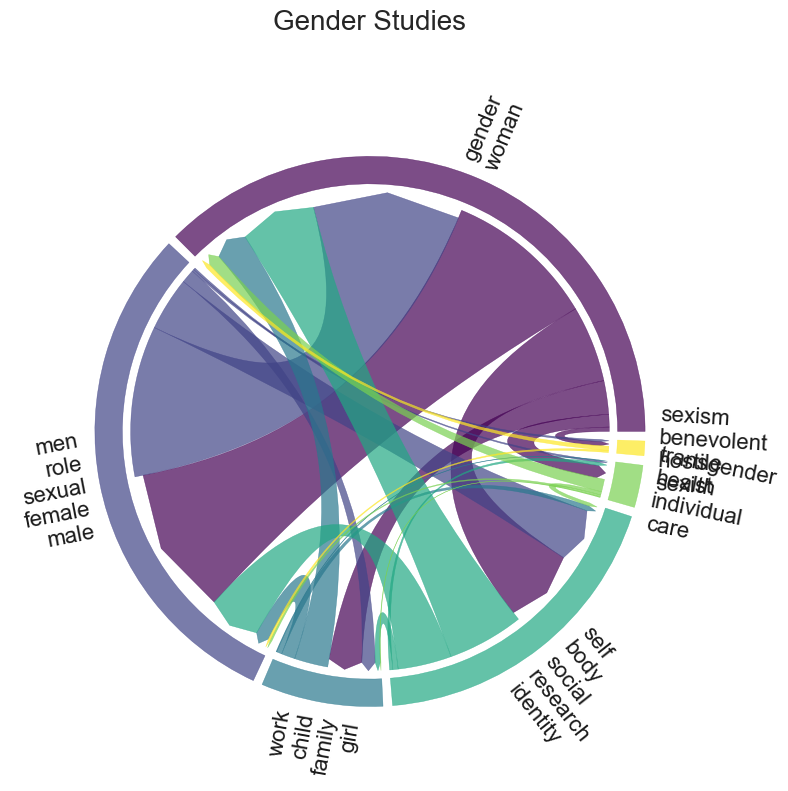

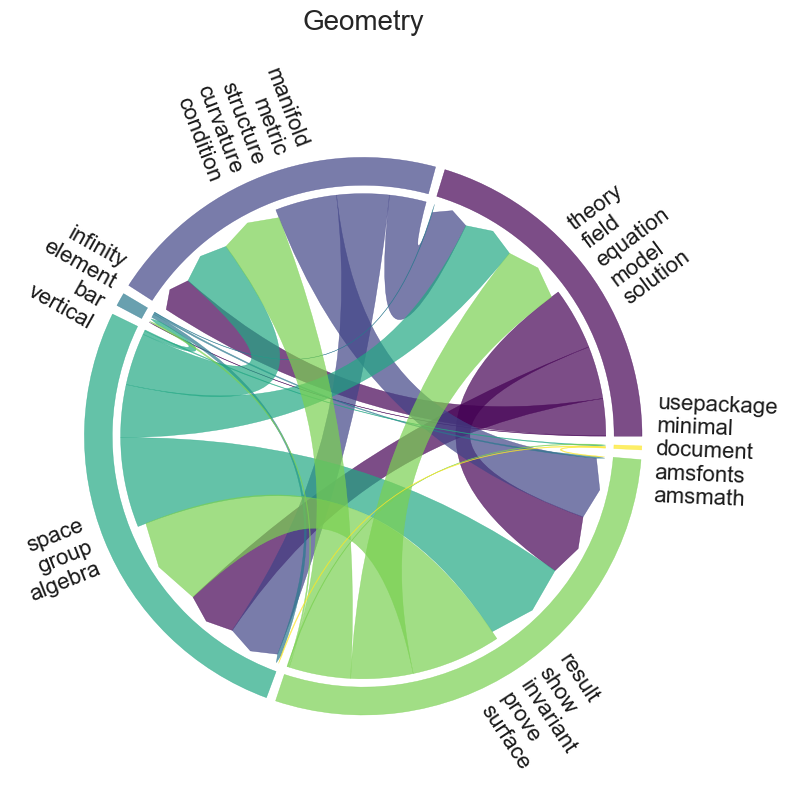

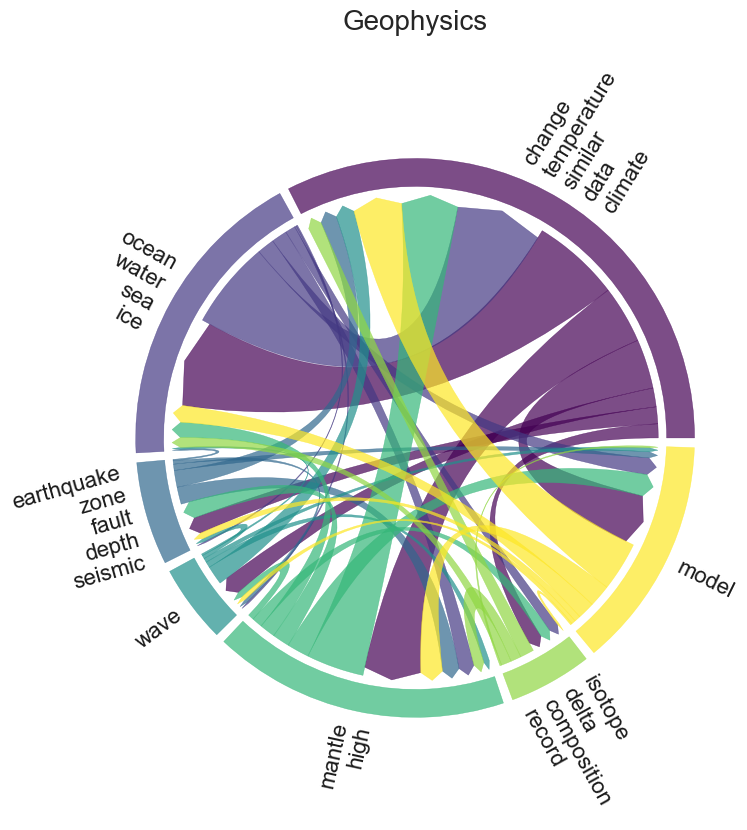

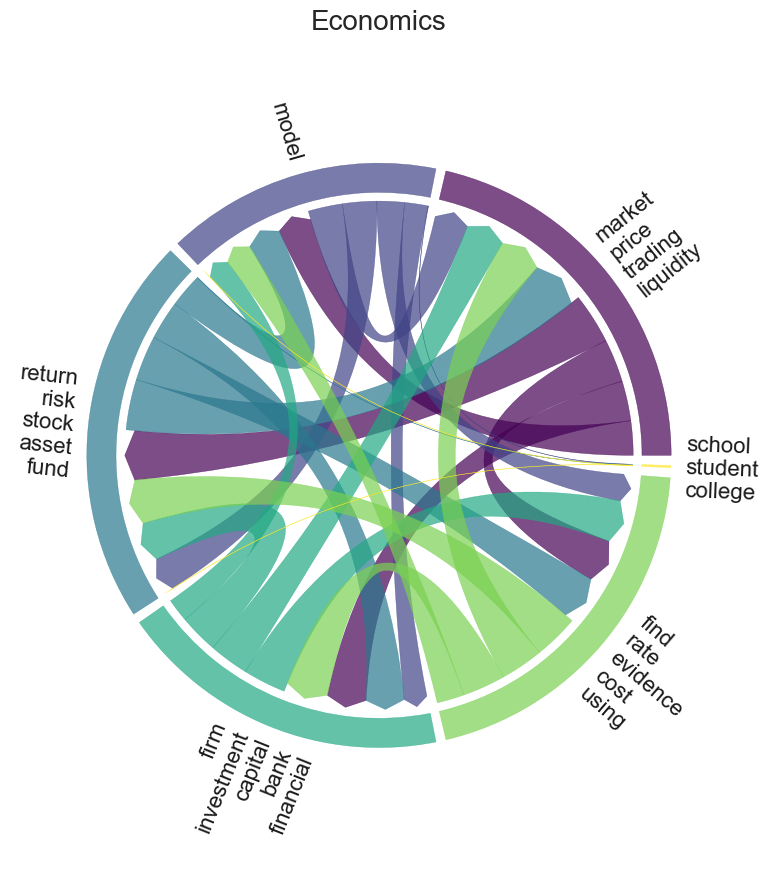

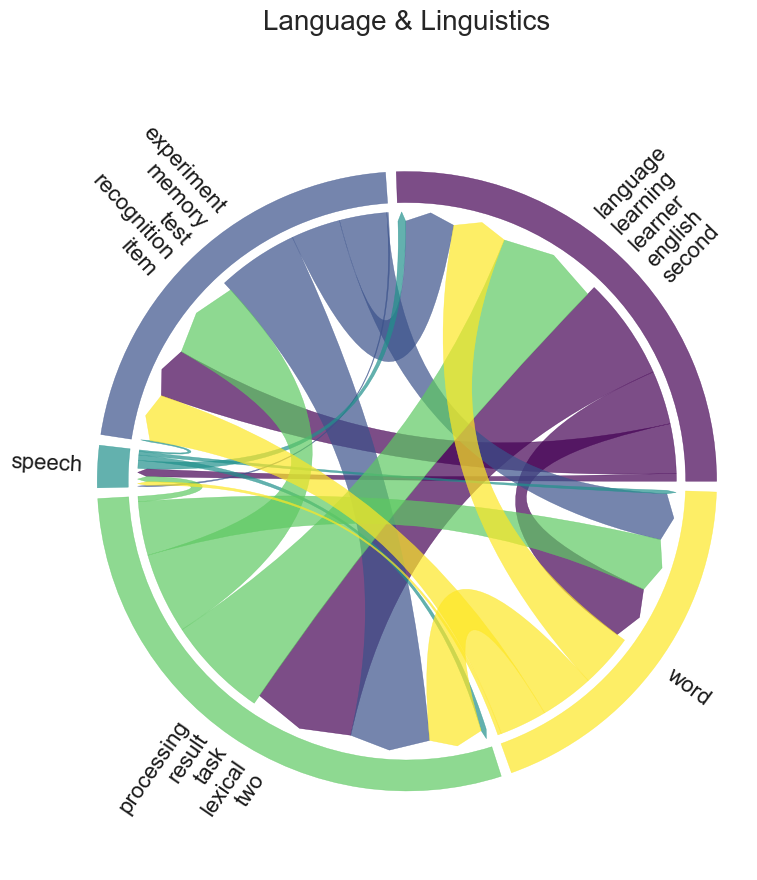

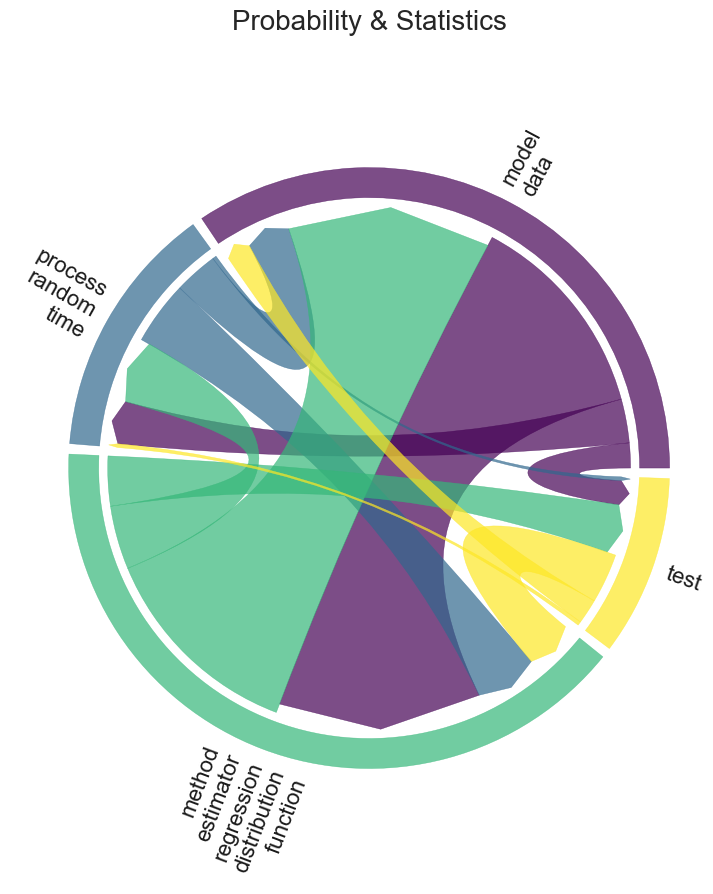

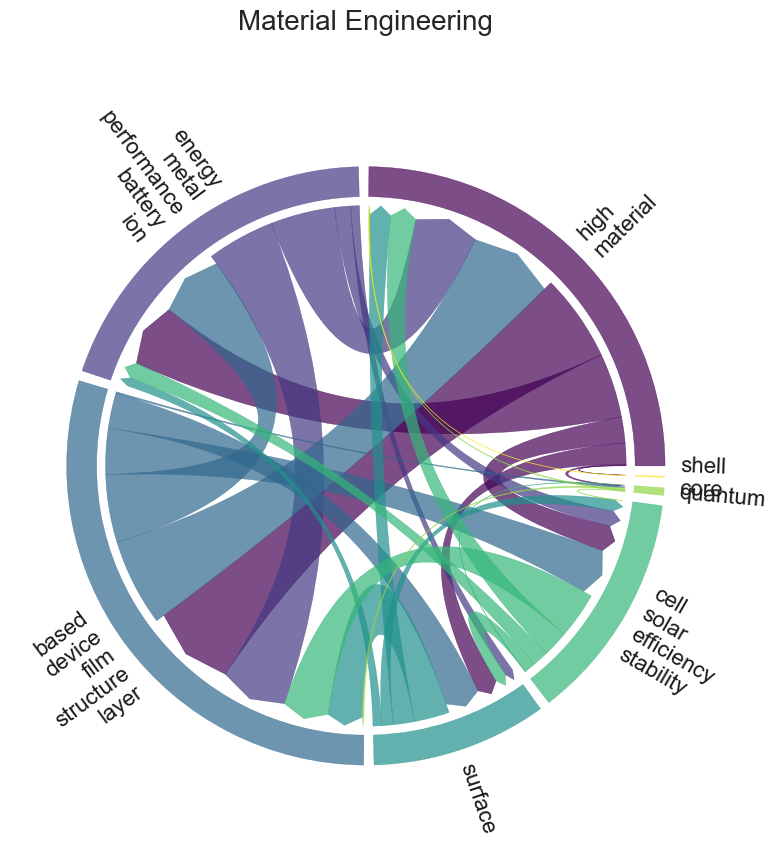

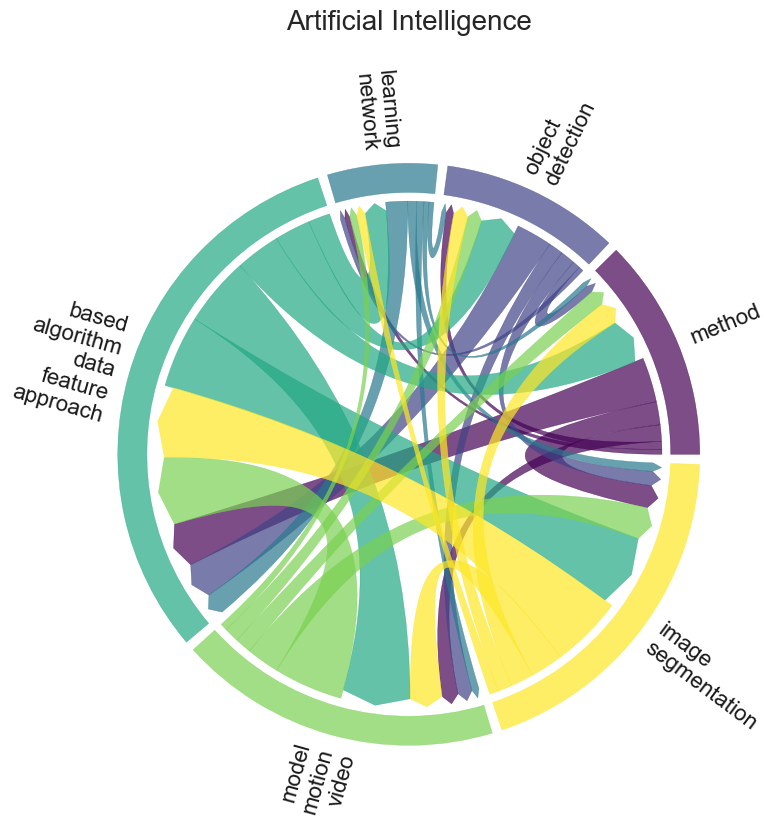

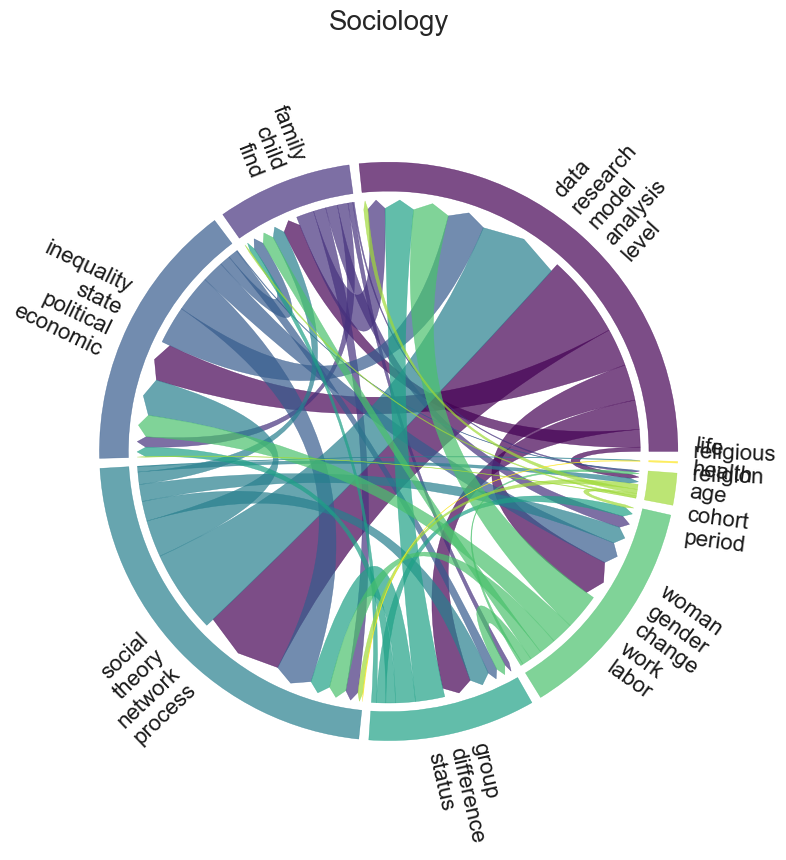

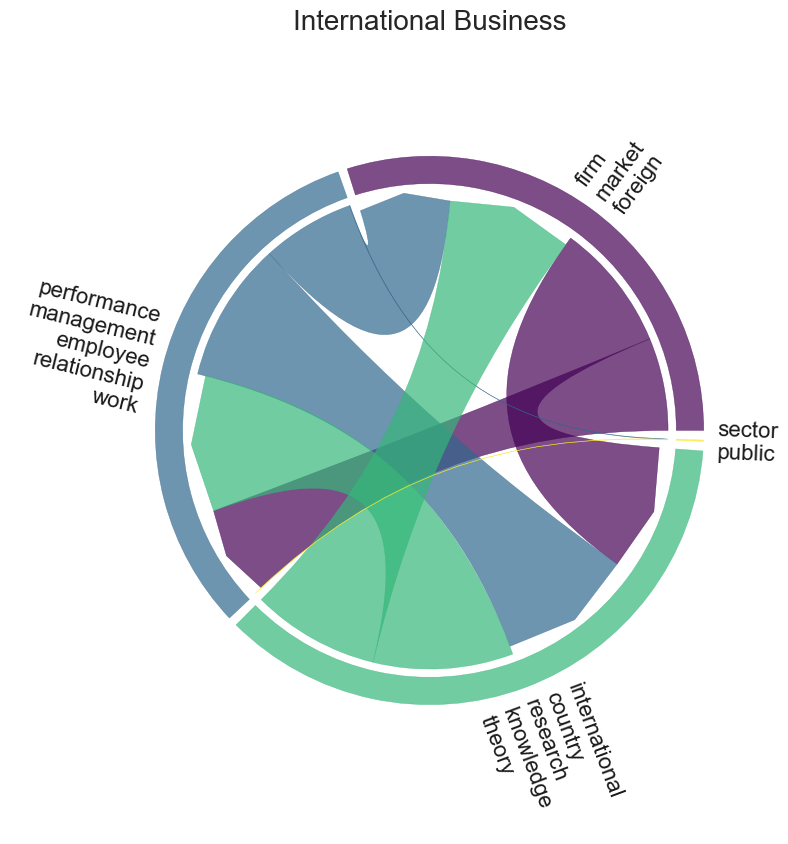

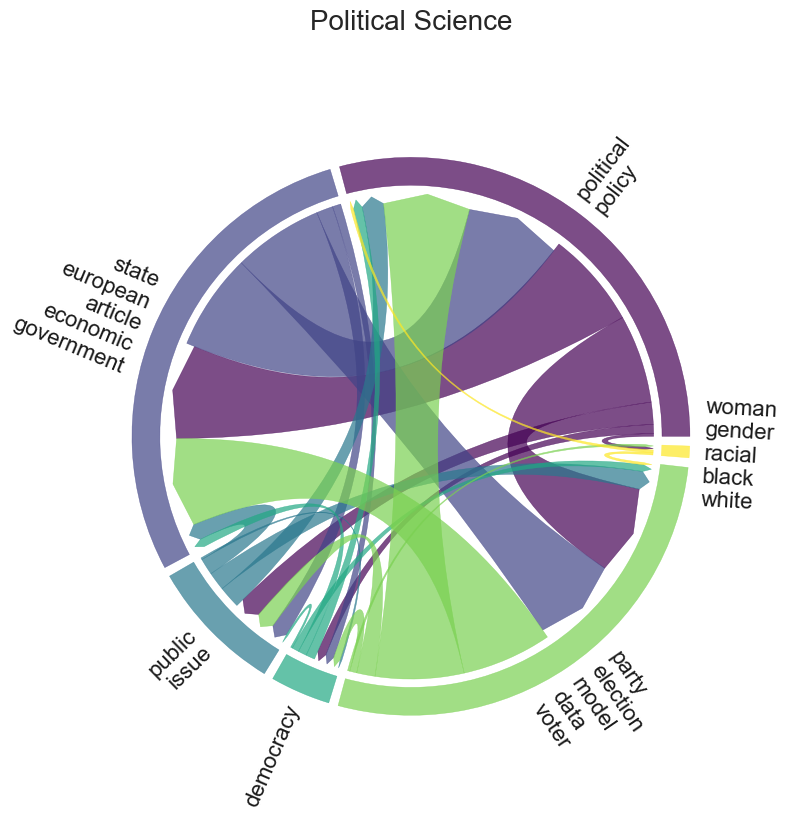

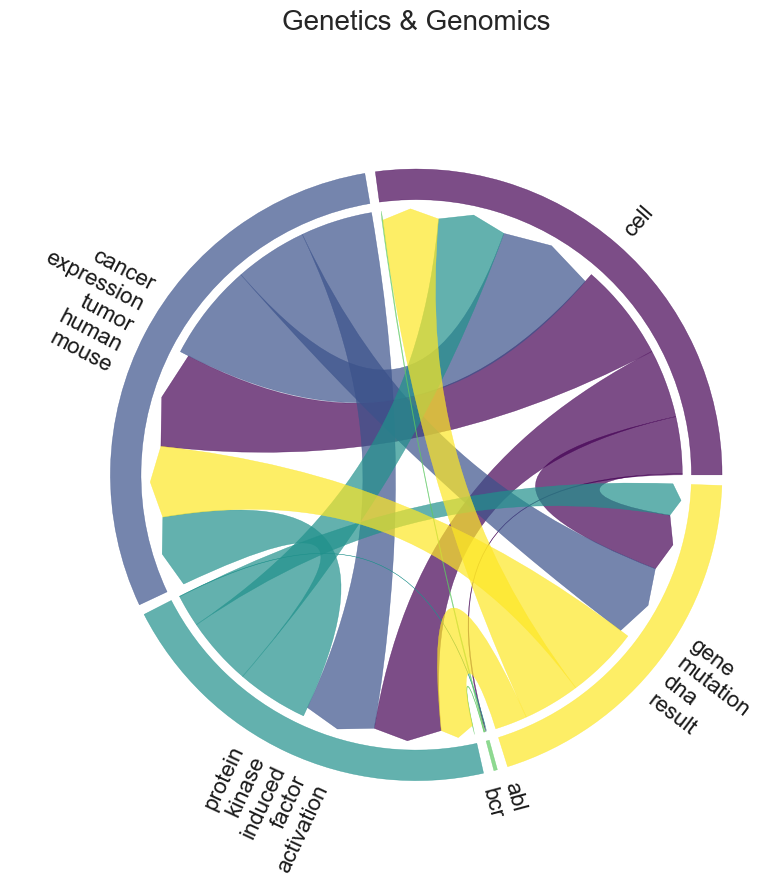

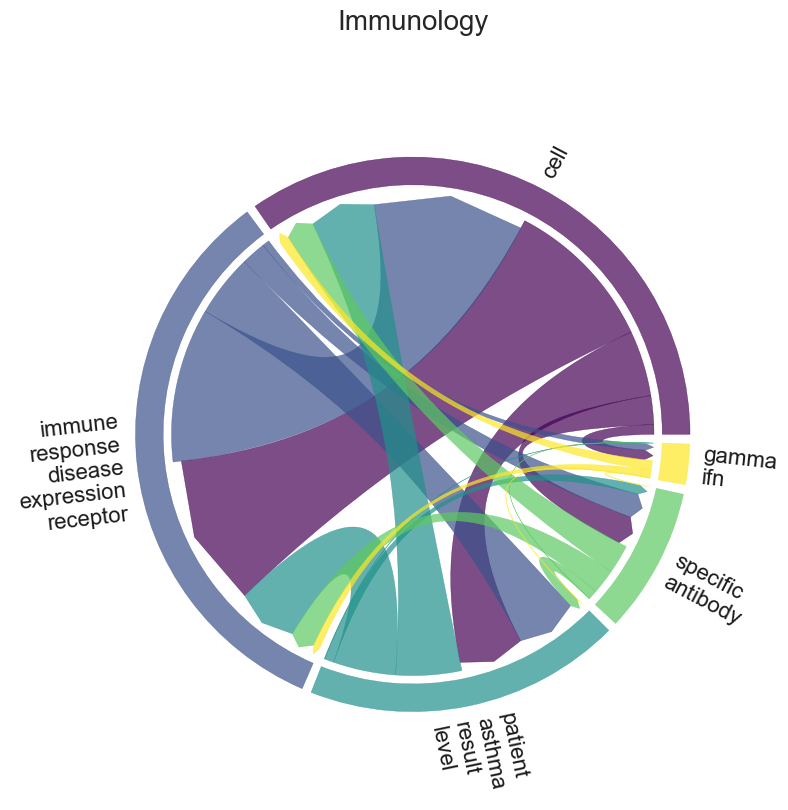

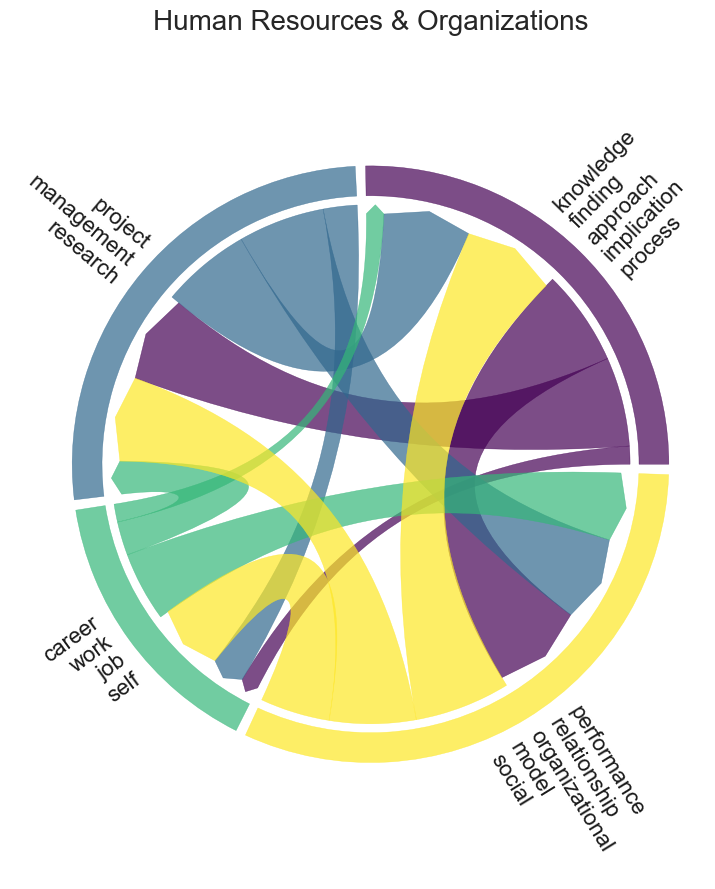

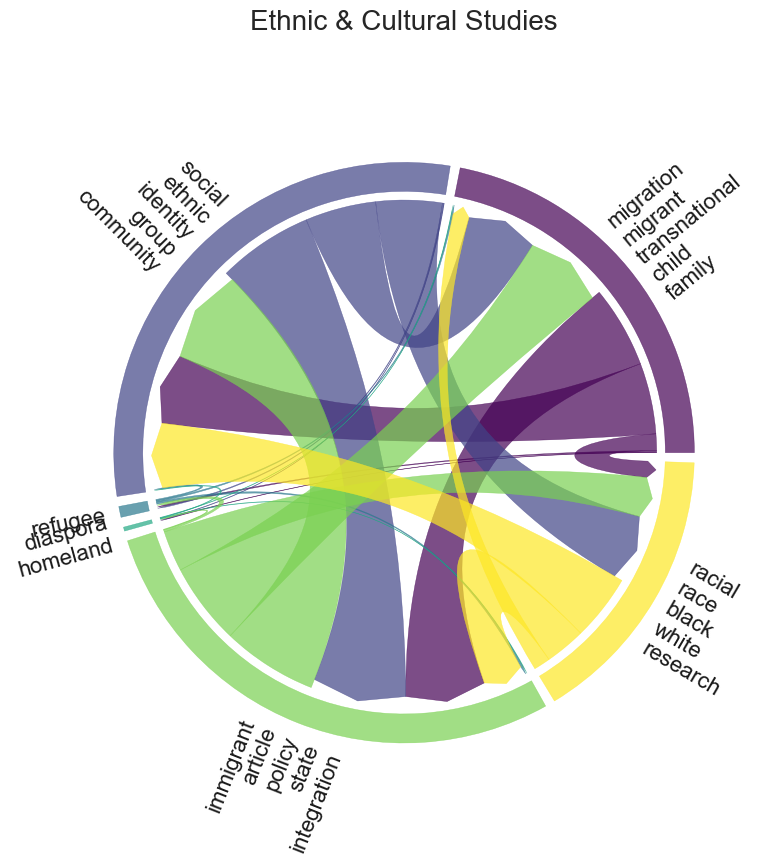

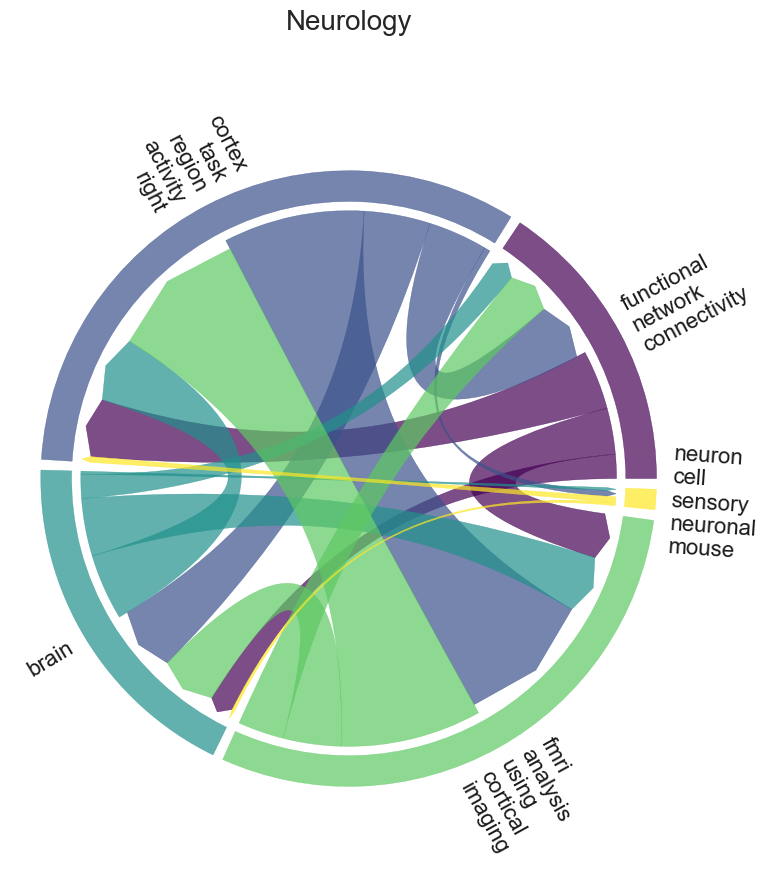

In [28]:
top_terms = 5

for field_name, G in Gs.items():

    # communities = [frozenset(c) for c in nx.community.louvain_communities(G)]
    communities = nx.community.louvain_communities(G)

    core_threshold = 3

    cores = nx.core_number(G)
    centrality = nx.degree_centrality(G)

    G_communities = nx.Graph()
    for community_i, community_j in itertools.combinations(communities, 2):
        
        edge_boundary = nx.edge_boundary(G, community_i, community_j)
        edge_weight = sum([G[u][v]['weight'] for (u, v) in edge_boundary])

        if edge_weight:

            community_core_i = dict(filter(lambda tup: tup[0] in community_i, cores.items()))
            community_core_i = dict(filter(lambda tup: tup[1] >= max(community_core_i.values())-core_threshold, community_core_i.items()))
            community_core_i = dict(sorted(community_core_i.items(), key=lambda tup: tup[1]))

            centrality_core_i = dict(filter(lambda t: t[0] in community_core_i, centrality.items()))
            centrality_core_i = sorted(centrality_core_i.items(), key=lambda t: t[1], reverse=True)
            centrality_core_i = [term for term, _ in centrality_core_i[:top_terms]]

            community_i_name = '\n'.join(centrality_core_i)

            community_core_j = dict(filter(lambda tup: tup[0] in community_j, cores.items()))
            community_core_j = dict(filter(lambda tup: tup[1] >= max(community_core_j.values())-core_threshold, community_core_j.items()))
            community_core_j = dict(sorted(community_core_j.items(), key=lambda tup: tup[1]))

            centrality_core_j = dict(filter(lambda t: t[0] in community_core_j, centrality.items()))
            centrality_core_j = sorted(centrality_core_j.items(), key=lambda t: t[1], reverse=True)
            centrality_core_j = [term for term, _ in centrality_core_j[:top_terms]]

            community_j_name = '\n'.join(centrality_core_j)

            G_communities.add_edge(community_i_name, community_j_name, weight=edge_weight)

    nodes = G_communities.nodes
    M = nx.adjacency_matrix(G_communities).toarray()


    fig, ax = plt.subplots(figsize=(8, 8))
    chord_diagram(M, names=nodes, directed=True, rotate_names=True, ax=ax, fontsize=16)
    ax.set_title(field_name, y=1.15, fontsize=20)

    fig.savefig(f'./chord/{field_name}.png', dpi=150, transparent=True, bbox_inches='tight')
    plt.show()